# Kaggle WM-811K dataset으로 wafer의 defect 불량을 CNN으로 검출해보기

In [ ]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

data = pd.read_pickle('LSWMD.pkl')
df = pd.DataFrame(data)

In [ ]:
df = pd.DataFrame(data)
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


데이터 세트는 811,457개의 웨이퍼 맵과 함께 웨이퍼 다이 크기, 로트(LOT(로트)란 제조단위(일한 조건 아래에서 만들어진 균일한 특성 및 품질을 갖는 제품군)로서 1회 검사 단위를 말한다) 이름 및 웨이퍼 인덱스와 같은 추가 정보로 구성됨

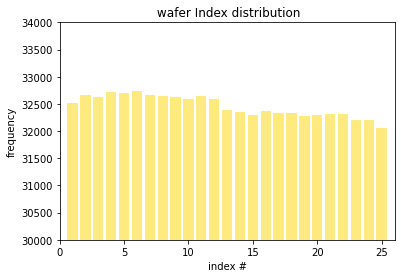

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

웨이퍼 인덱스별로 데이터의 분포가 고르지 않다.

웨이퍼 인덱스 기능은 분류에 필요하지 않기 때문에 feature engineering이 필요하다

In [ ]:
df = df.drop(['waferIndex'], axis = 1)

웨이퍼 맵 열에서는 많은 정보를 얻을 수 없지만 인스턴스별로 다이 크기가 다르다.

웨이퍼 맵 차원 검사를 위한 새로운 변수 'waferMapDim'을 만든다.

## 특정 해상도의 wafer map 가져오기

특정 해상도의의 서브 웨이퍼를 불러온다.

웨이퍼가 (26, 26) 해상도을 갖는다. 웨이퍼&array를 케이스 레이블로 정렬한다. 일부 웨이퍼에 Null 라벨이 있지만 무시한다.

In [ ]:
from skimage.transform import resize

def resize_img(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    
    if (dim0 >= 20 and dim0 <= 60) and (dim1 >= 20 and dim1 <= 60):
        return resize(x, (40,40))
    else: 
        return x
    
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

df['waferMap_resize'] =df.waferMap.apply(resize_img)
df['waferMapDim']=df.waferMap_resize.apply(find_dim)

In [ ]:
def reduce_none(x):
    if x == np.array([['none']]) and (np.random.rand() > 0.1) :
        return None
    else:
        return '1'
    
sub_df = df.loc[df['waferMapDim'] == (40, 40)]
sub_df = sub_df[sub_df.failureType != 0]

sub_df['reduce_none'] = sub_df.failureType.apply(reduce_none)
sub_df = sub_df.dropna()
sub_df = sub_df.drop(['reduce_none'], axis = 1)

sub_df.sample(10)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMap_resize,waferMapDim
808398,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",1060.0,lot47415,[[Test]],[[Loc]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
696321,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot42875,[[Training]],[[none]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
422858,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",1075.0,lot25392,[[Training]],[[Edge-Ring]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
790897,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46706,[[Training]],[[none]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
7597,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1393.0,lot1389,[[Training]],[[Loc]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
792394,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",562.0,lot46767,[[Test]],[[none]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
790944,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46708,[[Training]],[[none]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
775950,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1485.0,lot46101,[[Test]],[[none]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
709431,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43404,[[Training]],[[Edge-Loc]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"
336888,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,...",657.0,lot20289,[[Training]],[[Edge-Loc]],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(40, 40)"


In [ ]:
label = list()
sw = sub_df['waferMap_resize'].to_list()
sw = np.array(sw)
#sw = np.expand_dims(sw, axis=0)

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    #sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 28, 28)))
    
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = sw
y = np.array(label).reshape((-1,1))
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (36052, 40, 40), y shape : (36052, 1)


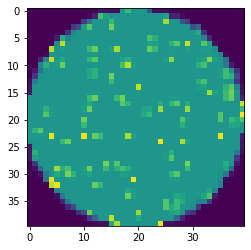

Faulty case : ['none'] 


In [ ]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [ ]:
x = x.reshape((-1, 40, 40, 1))

결함 있는 사례 목록을 작성하고 클래스가 imbalanced되는 방식을 확인

In [ ]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 4142
Donut : 519
Edge-Loc : 4949
Edge-Ring : 6775
Loc : 3326
Near-full : 148
Random : 843
Scratch : 994
none : 14356


웨이퍼 데이터의 각 픽셀에는 웨이퍼가 아닌 0, 1: 정상, 2: 결함을 나타내는 범주형 변수가 있다. 원-핫 인코딩된 단일 범주 데이터를 채널로 사용하여 추가 차원을 확장한다.

In [ ]:
# 정량적 변수들을 각 채널에 따라 원핫인코딩
new_x = np.zeros((len(x), 40, 40, 3))

for w in range(len(x)):
    for i in range(40):
        for j in range(40):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [ ]:
#check new x dimension
new_x.shape

(36052, 40, 40, 3)

In [ ]:
# 대체하지 않고 인덱스 선택
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=83, replace=False)]

# 지정한 인덱스 데이터 제거
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

print('"none" class 제거 후의 new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

"none" class 제거 후의 new_x shape : (35969, 40, 40, 3), new_y shape : (35969, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 4142
Donut : 519
Edge-Loc : 4949
Edge-Ring : 6775
Loc : 3326
Near-full : 148
Random : 843
Scratch : 994
none : 14273


In [ ]:
# 문자 라벨을 정량적 라벨로 만든다 
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# 원-핫인코딩
new_y = to_categorical(new_y)

#  train, test 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (24099, 40, 40, 3), y : (24099, 9)
Test x: (11870, 40, 40, 3), y : (11870, 9)


## sklearn kfold cross validation 이용해서 검증할 모델 생성.

In [ ]:
def create_model():
    input_shape = (40, 40, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

'''
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=256, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))
'''

"\n# Make keras model to sklearn classifier.\nmodel = KerasClassifier(build_fn=create_model, epochs=10, batch_size=256, verbose=2) \n# 3-Fold Crossvalidation\nkfold = KFold(n_splits=3, shuffle=True, random_state=2019) \nresults = cross_val_score(model, x_train, y_train, cv=kfold)\n# Check 3-fold model's mean accuracy\nprint('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))\n"

In [ ]:
batch_size=64
epoch = 20

model = create_model()
history = model.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=epoch, batch_size=batch_size)

Epoch 1/20
377/377 [==============================] - 36s 83ms/step - loss: 1.8080 - accuracy: 0.3906 - val_loss: 1.6976 - val_accuracy: 0.4034
Epoch 2/20
377/377 [==============================] - 31s 81ms/step - loss: 1.7029 - accuracy: 0.3936 - val_loss: 1.6934 - val_accuracy: 0.4034
Epoch 3/20
377/377 [==============================] - 31s 81ms/step - loss: 1.7026 - accuracy: 0.3936 - val_loss: 1.6994 - val_accuracy: 0.4034
Epoch 4/20
377/377 [==============================] - 30s 81ms/step - loss: 1.7005 - accuracy: 0.3936 - val_loss: 1.6945 - val_accuracy: 0.4034
Epoch 5/20
377/377 [==============================] - 30s 81ms/step - loss: 1.7027 - accuracy: 0.3936 - val_loss: 1.6978 - val_accuracy: 0.4034
Epoch 6/20
377/377 [==============================] - 31s 81ms/step - loss: 1.6990 - accuracy: 0.3936 - val_loss: 1.6917 - val_accuracy: 0.4034
Epoch 7/20
377/377 [==============================] - 32s 86ms/step - loss: 1.6991 - accuracy: 0.3936 - val_loss: 1.6910 - val_accuracy:

In [ ]:
score = model.evaluate(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score[1])

371/371 [==============================] - 3s 8ms/step - loss: 1.6912 - accuracy: 0.4034
Testing Accuracy: 0.40336984395980835


In [ ]:
def plot_model__hist(hist):
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.legend()
    plt.show()

    plt.figure()

    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc = "lower right")
    plt.show()

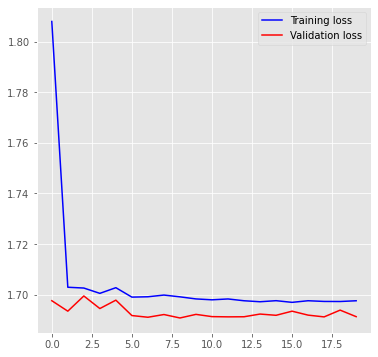

<Figure size 432x288 with 0 Axes>

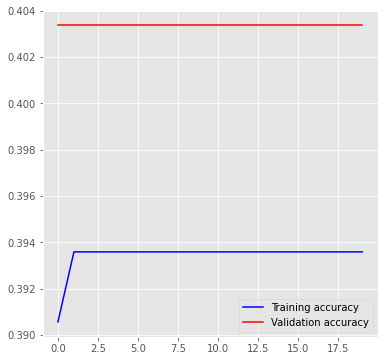

wafer defect 탐지 모델의 정확도: 40.00%


In [ ]:
plot_model__hist(history)
print("wafer defect 탐지 모델의 정확도: {:5.2f}%".format(100*round(score[1],2)))

In [ ]:
x_test_temp = np.delete(x_test, 1, axis=3)
x_test_temp = np.delete(x_test_temp, 1, axis=3)
x_test_temp = np.squeeze(x_test_temp,  axis=3)
print(x_test_temp.shape)

x_train_temp = np.delete(x_train, 1, axis=3)
x_train_temp = np.delete(x_train_temp, 1, axis=3)
x_train_temp = np.squeeze(x_train_temp,  axis=3)
print(x_train_temp.shape)

(11870, 40, 40)
(24099, 40, 40)


In [ ]:
y_list_train = []

for i in range(y_train.shape[0]):    
    j = 0
    while(j < 9):
        if( y_train[i][j]) == 1.0:
            y_list_train.append(j)
            break
        j+=1

y_list_test = []

for i in range(y_test.shape[0]):    
    j = 0
    while(j < 9):
        if( y_test[i][j]) == 1.0:
            y_list_test.append(j)
            break
        j+=1



        
df_test = pd.DataFrame(
    {'Image' : x_test_temp.tolist(),
     'labels' : y_list_test
     })


df_train  = pd.DataFrame(
    {'Image' : x_train_temp.tolist(),
     'labels' : y_list_train
     })

In [ ]:
import random

def create_pairs_5_shots(df, dataset_size, faulty_case):
    pairs = []
    
    for i in range(dataset_size):
                       
        class_nums = random.sample(range(0,faulty_case), 5)
        df_temp = df.loc[df['labels'] == class_nums[0]]
        sample = df_temp.sample(2)
        first_image = sample['Image'].values[0]
        second_image = sample['Image'].values[1]
    

        pairs.append([first_image,second_image])
        
        for j in range(1,5):
            df_temp = df.loc[df['labels'] == class_nums[j]]
            sample_temp = df_temp.sample(1)
            tem_image = sample_temp['Image'].values[0]
            pairs.append([first_image,tem_image])
            
          
        
    return np.array(pairs)
        
test_X_pair = create_pairs_5_shots(df_test, 2000, y_test.shape[1])

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout,Lambda, Conv1D,MaxPooling1D
from tensorflow.keras.models import Model
def base_network():
    input = Input(shape=(26, 26), name='base_input')
    layer1 = Conv1D(32, kernel_size = (3), 
                 activation = 'relu')(input)
    layer1 = MaxPooling1D(pool_size=2)(layer1)

    layer2 = Conv1D(64, kernel_size = (3), 
                 activation = 'relu')(layer1)
    layer2 = MaxPooling1D(pool_size=2)(layer2)
    
    layer3 = Conv1D(128, kernel_size = (3), 
                 activation = 'relu')(layer2)
    layer3 = MaxPooling1D(pool_size=2)(layer3)
    x = Flatten(name='flatten_input')(layer3)
    x = Dense(64, activation=None, name='first_base_dense')(x)  
    x = Dropout(0.3)(x)
    x = Dense(16, activation=None, name='second_base_dense')(x)   
    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))

base_model = base_network()


input_a = Input(shape=(26,26,), name='left_input')
vector_output_a = base_model(input_a)
input_b = Input(shape=(26,26,), name='right_input')
vector_output_b = base_model(input_b)
output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])
# define model
model_transfer_learning = Model([input_a, input_b], output)

model_transfer_learning.load_weights('fashion.h5')

y_pred = model_transfer_learning.predict([test_X_pair[:,0], test_X_pair[:,1]])
y_pred = y_pred.reshape(-1,5)

result = []

for i in range(y_pred.shape[0]):
    if (y_pred[i].min() == y_pred[i][0]):
        result.append(1.0)
    else:
        result.append(0.0)
        
score = np.mean(result)
print("Transfer Learning :" + str(score))

ValueError: in user code:

    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\user\.conda\envs\position31\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_2: expected shape=(None, 26, 26), found shape=(None, 40, 40)
